In [4]:
import time
import os
import cv2
import matplotlib.pyplot as plt
from lib.utilities import *
import numpy as np
import pandas as pd
import datetime

In [5]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
cell_type_prefix = 'scnn1a'
plt.rcParams.update({'font.size': 13})
#plt.rcParams['figure.figsize'] = [20, 12]

In [6]:
# work with latency data
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
csv_prefix = cell_type_prefix + '_all_slices-final.csv'
csv_columns = ['Date',
             'Slice/Loc/Rec',
             'Slice Location',
             'Stim Location',
             'L4 barrel 1 Latency',
             'L4 barrel 2 Latency',
             'L4 barrel 3 Latency',
             'L4 barrel 1 SNR',
             'L4 barrel 2 SNR',
             'L4 barrel 3 SNR',
             'ROI jpg',
              'Age',
              'Infusion',
              'Sex',
              'Stim (uA)',
              'Delta latency 1 (barrel 1 - barrel 2)',
              'Delta latency 2 (barrel 3 - barrel 2)']

# Load reference data for all slices
reference_file = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/" + cell_type_prefix + "_catalog.csv"
reference_df = pd.read_csv(reference_file)
ref_cols = ['Age', 
          'Sex', 
          "Infusion", 
          'Stim (uA)']

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Location,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,L4 barrel 2 SNR,L4 barrel 3 SNR,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
0,2/8/2023,02_01_02,NaN,L4,47.7369,49.4509,49.8291,1.551910,4.440250,3.035860,...,NaN,NaN,NaN,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134
1,2/10/2023,04_01_07,NaN,L4,52.7236,49.9505,51.1170,6.207490,13.131100,2.274550,...,2.7731,NaN,NaN,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632
2,2/14/2023,02_01_01,NaN,L4,47.5447,49.7343,49.9818,2.209280,2.558190,5.163110,...,NaN,NaN,NaN,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778
3,2/14/2023,03_01_03,NaN,L4,51.1559,50.3250,51.2512,4.770840,12.652100,6.629770,...,NaN,0.9262,NaN,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462
4,2/28/2023,04_01_06,NaN,L2/3,55.0473,52.3564,51.1973,1.274260,3.233650,4.785560,...,NaN,NaN,NaN,NaN,NaN,NaN,189.026639,198.000000,206.933090,142.367160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,6/28/2023,02_04_03,Posterior,L4,96.0000,57.9622,54.0523,0.000000,0.415489,0.306664,...,NaN,NaN,NaN,NaN,NaN,NaN,45.334980,103.683397,54.966572,139.137831
74,6/28/2023,03_01_10,Posterior,L4,50.9643,96.0000,96.0000,1.093020,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,89.704987,123.158200,257.644879,39.925056
75,6/28/2023,03_02_03,Posterior,L4,59.7131,96.0000,50.4657,0.080140,0.000000,0.730507,...,NaN,NaN,NaN,NaN,NaN,NaN,134.482759,102.498405,93.155627,118.731332
76,6/28/2023,03_03_01,Posterior,L4,96.0000,50.7756,57.9677,0.000000,1.992940,0.410993,...,NaN,NaN,NaN,NaN,NaN,NaN,67.012847,143.255826,23.814860,207.587278


In [7]:
# Repeat analysis (originally done in ROI-to-CSVdata.ipynb) but split by Rostral / caudal 
data = {}
snr_cutoff_signal = 5.0
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    data[stim_loc] = {}
    
    for slice_loc in ['Anterior', 'Posterior']:
        df2_sl = df2[df2['Slice Location'] == slice_loc]
        
        data[stim_loc][slice_loc] = {}

        print(slice_loc + " barrel pairs in", stim_loc)
        # count number of barrel pairs with no signal crossing
        n_barrel_no_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                   (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_no_cross, "no crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with signal crossing
        n_barrel_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_cross, "crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with no signal
        n_barrel_none = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal)])
        n_barrel_none += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal)])
        print("\t", n_barrel_none, "no signal out of", len(df2_sl) * 2, "in layer", stim_loc)
        
        data[stim_loc][slice_loc]['n_barrel_no_cross'] = n_barrel_no_cross
        data[stim_loc][slice_loc]['n_barrel_cross'] = n_barrel_cross
        data[stim_loc][slice_loc]['n_barrel_none'] = n_barrel_none
        data[stim_loc][slice_loc]['total'] = len(df2_sl) * 2 - n_barrel_none


Anterior barrel pairs in L2/3
	 3 no crossing out of 18 in layer L2/3
	 0 crossing out of 18 in layer L2/3
	 15 no signal out of 18 in layer L2/3
Posterior barrel pairs in L2/3
	 9 no crossing out of 20 in layer L2/3
	 1 crossing out of 20 in layer L2/3
	 10 no signal out of 20 in layer L2/3
Anterior barrel pairs in L4
	 8 no crossing out of 20 in layer L4
	 0 crossing out of 20 in layer L4
	 12 no signal out of 20 in layer L4
Posterior barrel pairs in L4
	 8 no crossing out of 34 in layer L4
	 1 crossing out of 34 in layer L4
	 25 no signal out of 34 in layer L4
Anterior barrel pairs in L5
	 0 no crossing out of 0 in layer L5
	 0 crossing out of 0 in layer L5
	 0 no signal out of 0 in layer L5
Posterior barrel pairs in L5
	 3 no crossing out of 6 in layer L5
	 1 crossing out of 6 in layer L5
	 2 no signal out of 6 in layer L5


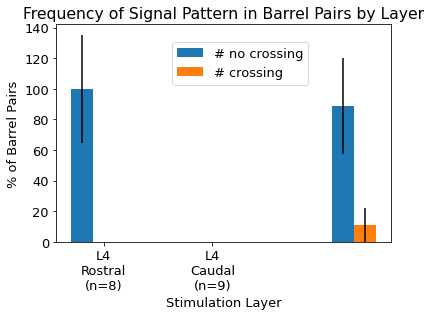

In [8]:
plt.clf()
i = 0
length_of_previous_sl = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5
for sl in ['Anterior', 'Posterior']:
    
    length_of_previous_sl = i
    
    n_L23 = data['L2/3'][sl]['total']
    n_L4 = data['L4'][sl]['total']
    n_L5 = data['L5'][sl]['total']
    
    all_layers = []
    totals = []
    if n_L23 > 0:
        pass
        #all_layers.append('L2/3')
        #totals.append(n_L23)
    if n_L4 > 0:
        all_layers.append('L4')
        totals.append(n_L4)
    if n_L5 > 0:
        pass
        #all_layers.append('L5')
        #totals.append(n_L5)
    
    
    # in columns L23, L4, L5
    crossing_data = {
        "# no crossing": [data[x][sl]['n_barrel_no_cross'] for x in all_layers],
        '# crossing': [data[x][sl]['n_barrel_cross'] for x in all_layers],
        #'# no signal': [data[x][sl]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
        #"L2/3": [3, 17, 30],
        #"L4": [38, 20, 30],
        #"L5": [8, 13, 1]
    }
    errbars = {}
    for k in crossing_data:
        errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
        for j in range(len(totals)):
            crossing_data[k][j] /= totals[j] / 100
            errbars[k][j] /= totals[j] / 100
            
    labels = [x for x in crossing_data.keys()]
    tick_labels += [all_layers[j] + "\n" + ("Rostral" if sl == "Anterior" else "Caudal") + "\n(n="+str(totals[j]) + ")"
                                for j in range(len(all_layers))]

    # plot this as bars 
    for nm in crossing_data:
        x = np.arange(length_of_previous_sl, len(all_layers) + length_of_previous_sl)
        '''        if i == length_of_previous_sl + 1:  # first iter of this sl
            plt.bar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    0.2,
                    label=nm,
                    tick_label=tick_labels)
                                #'L2/3\n(n='+str(n_L23)+')', 
                                #'L4\n(n='+str(n_L4)+')', 
                                #'L5\n(n='+str(n_L5)+')'])'''
        # else:
        plt.bar(x + (i-1) * 0.2, 
            crossing_data[nm],
            0.2,
            label=(nm if length_of_previous_sl == 0 else None),
            color=colors[nm])
        plt.errorbar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    yerr=errbars[nm],
                    fmt='none',
                    color='black')
        i += 1
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
plt.xticks(np.arange(len(tick_labels)), tick_labels)
#plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(0.55, .95), loc='upper center')
plt.savefig(data_dir + "results_count_prelim_" + str(datetime.date.today()) + ".png", bbox_inches="tight")
plt.show()

Latency between posterior (caudal) barrel pairs in L2/3
	 1.291 +/- 0.0 (n = 1)
	 [1.2911]
Latency between posterior (caudal) barrel pairs in L4
	 2.170 +/- 0.0 (n = 1)
	 [2.1705]
Latency between posterior (caudal) barrel pairs in L5
	 1.516 +/- 0.0 (n = 1)
	 [1.5165]


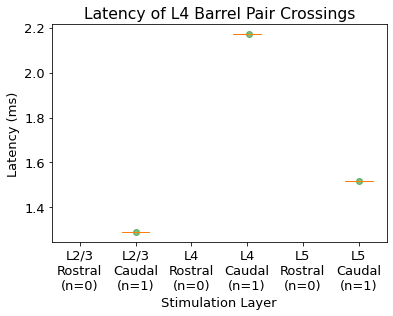

In [9]:
# plot latency spreads, separated by layer

df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])


plt.clf()
i = 1
xtick_labels = []
df_datasets = []
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    
    df2_ant = df2[df2['Slice Location'] == "Anterior"]
    dfd1_ant = df2_ant['abs(delta 1)'].dropna()
    dfd2_ant = df2_ant['abs(delta 2)'].dropna()
    
    df2_post = df2[df2['Slice Location'] == "Posterior"]
    dfd1_post = df2_post['abs(delta 1)'].dropna()
    dfd2_post = df2_post['abs(delta 2)'].dropna()
    
    dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
    dfds_post = np.concatenate([dfd1_post, dfd2_post])
    
    if len(dfds_ant) > 0:
        print("Latency between anterior (rostral) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_ant))[:5], 
              "+/-", 
              str(np.std(dfds_ant))[:5], 
              "(n =", 
              str(len(dfds_ant)) + ")")
        print("\t", dfds_ant)
    if len(dfds_post) > 0:
        print("Latency between posterior (caudal) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_post))[:5], 
              "+/-", 
              str(np.std(dfds_post))[:5], 
              "(n =", 
              str(len(dfds_post)) + ")")
        print("\t", dfds_post)
    if len(dfds_post) < 1 and len(dfds_ant) < 1:
        continue
    
    jittered_xs_1 = np.random.normal(i, 0.04, dfds_ant.shape[0])
    jittered_xs_2 = np.random.normal(i+1, 0.04, dfds_post.shape[0])
    plt.scatter(jittered_xs_1, dfds_ant, alpha=0.5, color='blue')
    plt.scatter(jittered_xs_2, dfds_post, alpha=0.5, color='green')

    xtick_labels.append(stim_loc + "\nRostral\n(n=" + str(len(dfds_ant)) +")")
    xtick_labels.append(stim_loc + "\nCaudal\n(n=" + str(len(dfds_post)) +")")
    df_datasets.append(dfds_ant)
    df_datasets.append(dfds_post)
    i += 2

plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_prelim_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()

In [10]:
# 6/30 single cell stim traces
traces_barrel_1 = data_dir + "06-30-23/selected_zda/Traces_03_02_04.dat"
traces_barrel_1 = pd.read_csv(traces_barrel_1,
                         sep='\t',
                         header=0,
                         names=['Index',  'Cell 1',  'Cell 2',  'Cell 3'])
print(traces_barrel_1)
plt.clf()
start_cut = 40
end_cut = 190
baseline = 10
v1 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 1"]] + baseline
v2 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 2"]] + baseline * 2
v3 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 3"]] + baseline * 3
t = [(i+start_cut) * 0.5 for i in range(len(v1))]
plt.plot(t, v1)
plt.plot(t, v2)
plt.plot(t, v3)
plt.axvline(x=48, label="Stimulation Time", color='red')
plt.legend(bbox_to_anchor=(0.75, 1.05), loc='upper center')
plt.yticks([])
plt.xlabel("Time (ms)")
plt.ylabel("Fluorescence Intensity / RLI")
plt.title("Responses to Single-Cell Stimulation (ai35hVOS/" + cell_type_prefix + "-Cre)")
plt.savefig(data_dir + "06-30-23/selected_zda/" + cell_type_prefix + "_traces-single-cell.png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/06-30-23/selected_zda/Traces_03_02_04.dat'